In [1]:
import jax
from jax import lax, random, numpy as jnp
import flax
import numpy as np
from flax import linen as nn

In [2]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


In [3]:
def frequency_encoding(x, min_period, max_period, dimension):
    periods = jnp.logspace(jnp.log10(min_period), jnp.log10(max_period), num=dimension)
    
    y = jnp.sin(2*jnp.pi/periods*x)
    return y

class MLP_single_wavelength_sine(nn.Module):
    architecture: tuple = (256, 256, 256, 256)
    @nn.compact
    def __call__(self, x):
        w = x
        enc_w = frequency_encoding(w, min_period=1e-5, max_period=1.0, dimension=128)
        _x = enc_w
        for features in self.architecture:
            _x = nn.relu(nn.Dense(features)(_x))
        x = nn.Dense(1, bias_init=nn.initializers.ones)(_x)
        return x
    
class MLP_wavelength_sine(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, train):
        log_waves = inputs
        
        DecManyWave = nn.vmap(
                    MLP_single_wavelength_sine, 
                    in_axes=0, out_axes=0,
                    variable_axes={'params': None}, 
                    split_rngs={'params': False})
        
        x = DecManyWave(name="decoder")(log_waves)
        x = x[...,0]
        return x

In [28]:
log_wave = np.linspace(np.log10(3000),np.log10(7000),100000)
log_wave

array([3.47712125, 3.47712493, 3.47712861, ..., 3.84509068, 3.84509436,
       3.84509804])

In [29]:
NO_SAMPLES = 1000
LEARNING_RATE = 1.0
WARM_UP_STEPS = 10
TRAINING_STEPS = 100
from flax.training import train_state, checkpoints
import optax
def create_train_state(rng, model):
    """Creates initial `TrainState`."""
    m = model()
    dummpy_input = jnp.ones(NO_SAMPLES)
    params = m.init(rng, dummpy_input, False)['params']
    
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=LEARNING_RATE,
        warmup_steps=WARM_UP_STEPS,
        decay_steps=TRAINING_STEPS-WARM_UP_STEPS,
        end_value=0.0,
    )
    tx = optax.adam(learning_rate=schedule)

    return train_state.TrainState.create(apply_fn=m.apply, params=params, tx=tx)

In [30]:
model_name = "MLP_sine"
CHECKPOINTS_DIR = "ckpts"
prefix = f"checkpoint_{model_name}_"
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CHECKPOINTS_DIR, target=None, prefix=prefix)
restored_params = restored_state["params"]

In [31]:
m = MLP_wavelength_sine()
dummpy_input = jnp.zeros_like(log_wave)

rng = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}
params = m.init(rng, dummpy_input, False)['params']

flux = m.apply({'params': restored_params}, 
                log_wave, 
                train=False
               )

<IPython.core.display.Javascript object>


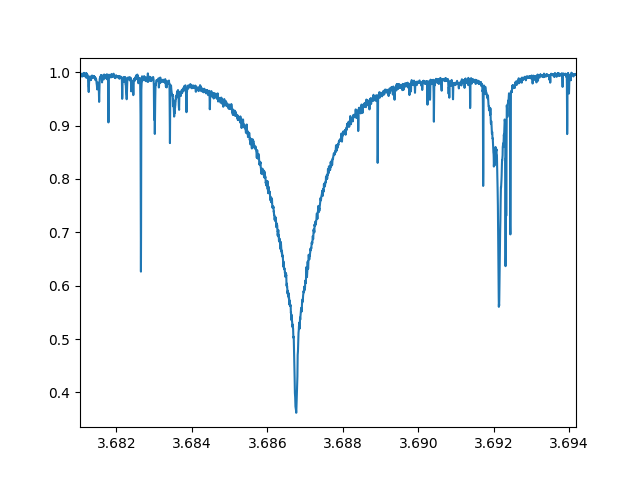

In [32]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(log_wave,flux)